In [2]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from sklearn.linear_model import RidgeCV

plt.rcParams.update({'font.size': 10,
                    'axes.spines.right': False,
                    'axes.spines.top':   False,
                    'legend.frameon':       False,})


# plt.rcParams.update({'font.size': 10,
#                     'axes.spines.right': False,
#                     'axes.spines.top':   False,
#                     'legend.frameon':       False,
#                     'font.sans-serif': 'Helvetica',
#                     'svg.fonttype': 'none'})

# Load the data
filepath = "SSTindivsomata_GLM.mat"
data_dict = mat73.loadmat(filepath)

In [25]:
num_animals = len(data_dict['animal']['ShiftLrate'])
reorganized_data = {}

# Define indices for slicing the spatial bins
bin_slices = [
    slice(0, 10),  
    slice(10, 20),  
    slice(20, 30),  
    slice(30, 40),  
    slice(40, 50)   
]

spatial_bin_matrix = np.zeros((50, 5))
        
spatial_bin_matrix[bin_slices[0], 0] = 1
spatial_bin_matrix[bin_slices[1], 1] = 1
spatial_bin_matrix[bin_slices[2], 2] = 1
spatial_bin_matrix[bin_slices[3], 3] = 1
spatial_bin_matrix[bin_slices[4], 4] = 1

variable_list = []

for animal_idx in range(num_animals):
    neuron_list = []
    
    num_neurons = data_dict['animal']['ShiftR'][animal_idx].shape[2]
   
    for neuron_idx in range(1, num_neurons):
        neuron_data = []
        neuron_data.append(data_dict['animal']['ShiftR'][animal_idx][:, :, neuron_idx]) # Neuron activity
        variable_list.append('Activity') if neuron_idx == 1 and animal_idx == 0 else None
        
        neuron_data.append(data_dict['animal']['ShiftLrate'][animal_idx])               # Lick rate
        variable_list.append('LickRate') if neuron_idx == 1 and animal_idx == 0 else None

        neuron_data.append(data_dict['animal']['ShiftV'][animal_idx])                   # Reward location (valve opening)
        variable_list.append('RewardLocation') if neuron_idx == 1 and animal_idx == 0 else None

        neuron_data.append(data_dict['animal']['ShiftRunning'][animal_idx])             # Running speed  
        variable_list.append('RunningSpeed') if neuron_idx == 1 and animal_idx == 0 else None

        combined_matrix = np.stack(neuron_data, axis=1)

        # Add variable for actual reward delivered (licks at reward location)   
        licking_on_reward = data_dict['animal']['ShiftLrate'][animal_idx] * data_dict['animal']['ShiftV'][animal_idx]      
        licking_on_reward_expanded = licking_on_reward[:, np.newaxis, :]  
        combined_matrix = np.concatenate((combined_matrix, licking_on_reward_expanded), axis=1)
        variable_list.append('LickingOnReward') if neuron_idx == 1 and animal_idx == 0 else None

        # Add position variables to the data matrix
        expanded_spatial_bin_matrix = np.repeat(spatial_bin_matrix[:, :, np.newaxis], combined_matrix.shape[2], axis=2) # Copy along the 'trials' dimension
        expanded_spatial_bin_matrix = np.roll(expanded_spatial_bin_matrix, 5, axis=0)
        combined_matrix = np.concatenate((combined_matrix, expanded_spatial_bin_matrix), axis=1)
        variable_list.extend(['Position 1', 'Position 2', 'Position 3', 'Position 4', 'Position 5']) if neuron_idx == 1 and animal_idx == 0 else None
        
        neuron_list.append(combined_matrix)

    reorganized_data[f'animal_{animal_idx + 1}'] = neuron_list


# print(f"Shape of the combined matrix for the first neuron of animal_1: {reorganized_data['animal_1'][0].shape}")
# print(f"Total number of animals in dictionary: {len(reorganized_data)}")
# print(f"Number of neurons for animal_1: {len(reorganized_data['animal_1'])}")        
  

In [5]:
GLM_params = {}

for animal in reorganized_data:
    GLM_params[animal] = {}
    for i,neuron in enumerate(reorganized_data[animal]):
        flattened_data = neuron.reshape(neuron.shape[0]*neuron.shape[2], neuron.shape[1]) # Combine trials and spatial bins into a single dimension
        flattened_data = flattened_data[~np.isnan(flattened_data).any(axis=1)] # Remove rows with NaNs
        flattened_data = (flattened_data - np.min(flattened_data, axis=0)) / (np.max(flattened_data, axis=0) - np.min(flattened_data, axis=0)) # Normalize between 0 and 1 

        design_matrix_X = flattened_data[:, 1:]
        neuron_activity = flattened_data[:, 0]
        ridge_cv = RidgeCV(alphas=[0.1, 1, 10, 100, 1000, 5000], store_cv_results=True)
        ridge_cv.fit(design_matrix_X, neuron_activity)

        GLM_params[animal][i] = {'weights': ridge_cv.coef_, 
                                 'intercept': ridge_cv.intercept_, 
                                 'alpha': ridge_cv.alpha_, 
                                 'cv_results': np.mean(ridge_cv.cv_results_, axis=0)}
        

TypeError: _BaseRidgeCV.__init__() got an unexpected keyword argument 'store_cv_results'

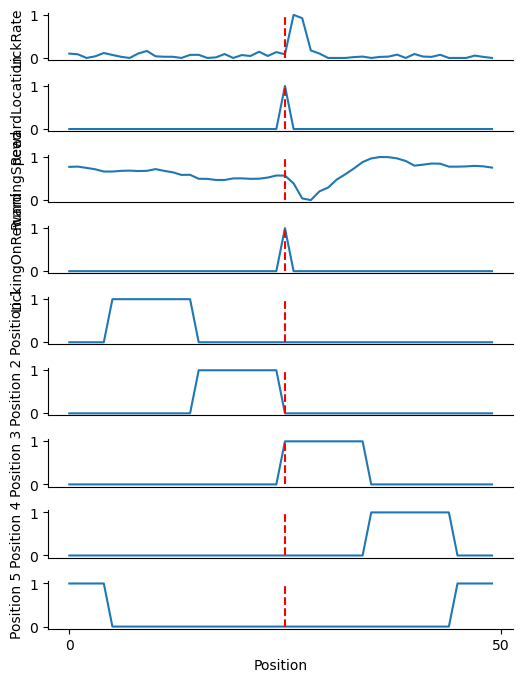

In [31]:
example_neuron = 0
example_animal = 'animal_1'
example_data = np.nanmean(reorganized_data[example_animal][example_neuron][:,:,1:], axis=2)
example_data = (example_data - np.min(example_data, axis=0)) / (np.max(example_data, axis=0) - np.min(example_data, axis=0))
example_neuron_activity = example_data[:, 0]
example_variables = example_data[:, 1:]


fig = plt.figure(figsize=(6, 8))
axes = gs.GridSpec(nrows=example_variables.shape[1], ncols=1, figure=fig, 
                   wspace=0.1, hspace=0.5)

for i in range(example_variables.shape[1]):
    ax = fig.add_subplot(axes[i])
    ax.plot(example_variables[:, i])
    ax.set_ylabel(variable_list[i+1])
    ax.vlines(25, 0, 1, linestyles='--', color='r')
    if i == example_variables.shape[1] - 1:
        ax.set_xlabel('Position')
        ax.set_xticks([0,50])
    else:
        ax.set_xticks([])

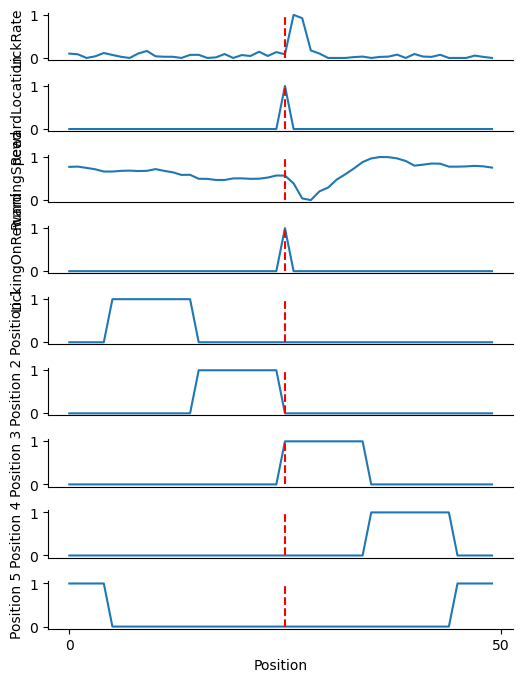

In [31]:
example_neuron = 0
example_animal = 'animal_1'
example_data = np.nanmean(reorganized_data[example_animal][example_neuron][:,:,1:], axis=2)
example_data = (example_data - np.min(example_data, axis=0)) / (np.max(example_data, axis=0) - np.min(example_data, axis=0))
example_neuron_activity = example_data[:, 0]
example_variables = example_data[:, 1:]


fig = plt.figure(figsize=(6, 8))
axes = gs.GridSpec(nrows=example_variables.shape[1], ncols=1, figure=fig, 
                   wspace=0.1, hspace=0.5)

for i in range(example_variables.shape[1]):
    ax = fig.add_subplot(axes[i])
    ax.plot(example_variables[:, i])
    ax.set_ylabel(variable_list[i+1])
    ax.vlines(25, 0, 1, linestyles='--', color='r')
    if i == example_variables.shape[1] - 1:
        ax.set_xlabel('Position')
        ax.set_xticks([0,50])
    else:
        ax.set_xticks([])

In [6]:
from sklearn.model_selection import cross_val_score

GLM_params = {}

for animal in reorganized_data:
    GLM_params[animal] = {}
    for i, neuron in enumerate(reorganized_data[animal]):
        flattened_data = neuron.reshape(neuron.shape[0] * neuron.shape[2], neuron.shape[1]) 
        flattened_data = flattened_data[~np.isnan(flattened_data).any(axis=1)]  

        normalized_data = (flattened_data - np.mean(flattened_data, axis=0)) / np.std(flattened_data, axis=0)  # Z-score the data
        design_matrix_X = flattened_data[:, 1:]
        neuron_activity = flattened_data[:, 0]

        ridge_cv = RidgeCV(alphas=[0.1, 1, 10, 100, 1000, 5000])
        ridge_cv.fit(design_matrix_X, neuron_activity)
        
        scores = cross_val_score(ridge_cv, design_matrix_X, neuron_activity, cv=5)

       
        GLM_params[animal][i] = {
            'weights': ridge_cv.coef_, 
            'intercept': ridge_cv.intercept_, 
            'alpha': ridge_cv.alpha_,
            'cv_scores': np.mean(scores)  
        }


<BarContainer object of 9 artists>

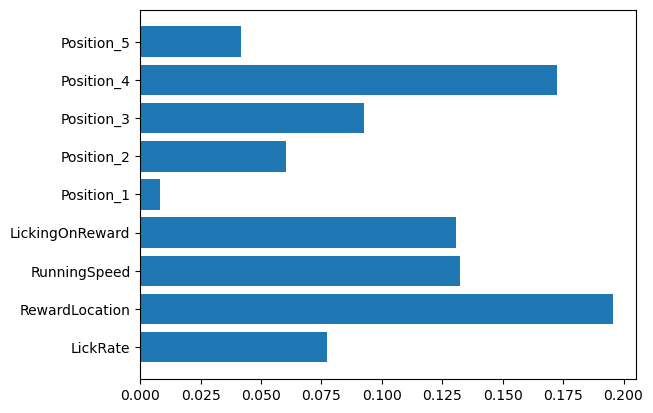

In [7]:
neuron_nr = 2

# Bar graph
plt.barh(variable_list[1:], GLM_params['animal_4'][neuron_nr]['weights'])

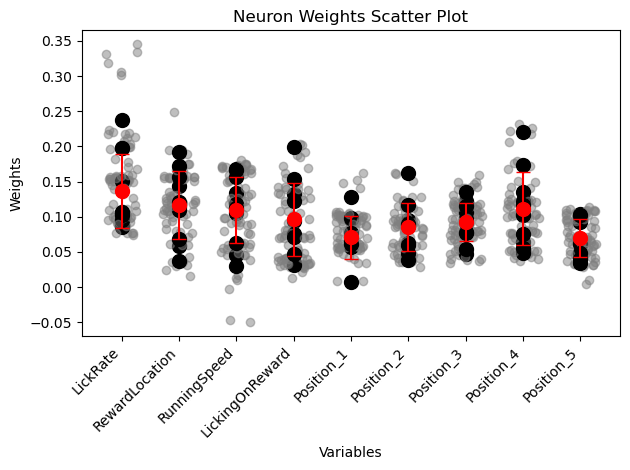

In [26]:


# variable_list = ['LickRate', 'RewardLocation', 'RunningSpeed', 'LickingOnReward',
#                  'Position_1', 'Position_2', 'Position_3', 'Position_4', 'Position_5']

animal_averages = []
# animal_sems = []
animal_stds = []

jitter_strength = 0.28

for animal_key in GLM_params:
    neuron_weights = []
    for neuron_nr in range(len(GLM_params[animal_key])):
        neuron_weights.append(GLM_params[animal_key][neuron_nr]['weights'])
        
        jittered_x = np.arange(len(variable_list[1:])) + np.random.uniform(-jitter_strength, jitter_strength, len(variable_list[1:]))
        
        # plotting neurons in grey
        plt.scatter(jittered_x, GLM_params[animal_key][neuron_nr]['weights'], color='grey', alpha=0.5)
    
    neuron_weights = np.array(neuron_weights)
 
    mean_weights = np.mean(neuron_weights, axis=0)
#     sem_weights = np.std(neuron_weights, axis=0) / np.sqrt(neuron_weights.shape[0])
    std_weights = np.std(neuron_weights, axis=0)  # Use standard deviation
    
    animal_averages.append(mean_weights)
#     animal_sems.append(sem_weights)
    animal_stds.append(std_weights)
    
    # animal mean = black dot
    plt.scatter(range(len(variable_list[1:])), mean_weights, color='black', label=f'Animal {animal_key}', s=100)

animal_averages = np.array(animal_averages)
# animal_sems = np.array(animal_sems)
animal_stds = np.array(animal_stds)


global_mean = np.mean(animal_averages, axis=0)
global_std = np.std(animal_averages, axis=0)
# global_sem = np.sqrt(np.sum(animal_sems**2, axis=0)) / len(animal_sems)

plt.errorbar(range(len(variable_list[1:])), global_mean, yerr=global_std, fmt='o', color='red', ecolor='red', 
             capsize=5, label='Average of all animals', markersize=10)

plt.xticks(range(len(variable_list[1:])), variable_list[1:], rotation=45, ha='right')
plt.xlabel('Variables')
plt.ylabel('Weights')
plt.title('Neuron Weights Scatter Plot')


plt.tight_layout()
plt.show()
